# Analyzing FUMBBL Blood Bowl team strength using Python

This blogpost is about **Blood Bowl**, a boardgame invented in the mid-90s, that I finally started playing last year. Blood bowl is a game of Fantasy Football, where fantasy team races (think "Orcs", or "Elves") are pitted against each other. Interestingly, the various teams require different play styles, and not all team races are equally strong. There exists a lively tournament scene, with thousands of matches played each year. 

Blood Bowl is a two player game on a board, with playing pieces, like Chess. But instead of two medieval kingdoms fighting, Blood Bowl is about fantasy football, say Tolkien meets rugby. It appealed to me as a teenager (I bought the game in 1994) because it combined the Warhammer playing pieces I liked so much (miniature models "minis" of Orcs, Elves, Dwarves etc) with simple game mechanics that resulted in complex gameplay. Blood bowl requires a lot of skill to play well, with complex strategic decision making under uncertainty (there is heavy dice rolling involved). Blood Bowl is very much alive nowaydays: Since its invention 30 years ago, an international gaming community has formed around the game, with a players' association, the NAF, with thousands of members, a World championship every two years, and with new editions and models being released on a regular basis.

Blood Bowl also went online: A paid version called "Blood Bowl 2" with fancy 3D graphics is available on [Steam](https://store.steampowered.com/app/236690/Blood_Bowl_2/). However, a more basic (2D) version is freely available as [**FUMBBL**](https://fumbbl.com). It uses a Java client that uploads game results to an online server with an accompanying website that supports the managerial and community aspects of the game (Forming teams, using winnings to buy new players, displaying statistics such as coach rankings, organizing tournaments, forum discussions etc).

In 2020, a new version of the game came out with several changes to the rules, and containing new teams to play with. Some teams became less strong (they got "nerfed"), and some teams benefitted (they were "buffed"). Out of curiosity, I decided to compile a dataset of Blood Bowl matches played online at FUMBBL.com (detailed in [this companion blog post](https://gsverhoeven.github.io/post/blood-bowl-fumbbl-dataset/) to analyse the win rates of the different teams and how these have been impacted by the new ruleset. 

To complicate matters somewhat, the Blood Bowl game has two "main" modes of play: **League play** and **Tournament play**. In **league play**, teams develop themselves as they gain so-called Star Player Points (SPP), and as they develop, players amass skills (get stronger), or get hurt (being forced to miss the next game, or worse, die). In **Tournaments** on the other hand, coaches design a team beforehand, and get a fixed budget of skills for their players. Then during the tournament, each round teams are "resurrected", without anything carrying over from the previous round.

As I was learning more about the intricacies of the game, I gradually realized that it is difficult to draw conclusions that generalize from **League play** to **Tournament play** and vice versa. And even given one of these play modes, details matter, as well shall see.

The idea of this blog post is to learn about Blood Bowl through data analysis of both NAF and FUMBBL datasets, taking into account the different circumstances of how these data were generated, and see what we can learn. So lets dive in the world of Blood Bowl stats nerdery.

# Reproducing the analyses in this post

This blogpost is written as a Jupyter notebook containing Python code, and is fully reproducible. The idea is to make Blood Bowl data analysis accessible to others. Using open source tooling reduces the barriers for others to build on other people’s work.

In [1]:
import random
import time

import pandas as pd
import numpy as np
import plotnine as p9

# Function for computing confidence intervals
from statsmodels.stats.proportion import proportion_confint   

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


# Not all teams are created equal: tiers in Blood Bowl

There are currently 28 "official" races / different teams, such as orcs, elves, humans etc.
Each race has different player types, with different strength, abilities, skills, etc.

As already mentioned above, Blood Bowl is not balanced with respect to the different team "races" available. For example, it is much harder to win a match playing with a **Vampires** team, compared to playing with an **Orc** team. Not surprisingly, teams that have a higher probability of winning are more popular both in Tabletop tournaments as well as online at FUMBBL. 

For Blood Bowl, A tier system (strength ranking) consisting of three groups exists already for some time. This system (or some refined version of it) is used in Tournaments to achieve more balance, and equalize win probabilities of the different teams. Each team is in of the three groups, with tier 1 teams being the strongest teams, and tier 3 teams the weakest teams.

Below I made a visualization of these three groups, as well as the new BB2020 tiers per the 2020 rulebook, and per the update of November 2021. For **Humans** and **Old World Alliance** the NAF and GW appear to differ from opinion, as an [oktober '21 NAF online tournament](https://fumbbl.com/p/group?op=view&group=9298) places both of them in Tier 2, whereas the rulebook has them both in Tier 1.

[According to Games Workshop](https://www.warhammer-community.com/2021/11/29/the-only-thing-arriving-with-a-bigger-bang-than-barik-farblasts-bazooka-is-todays-blood-bowl-faq/):

*With tournaments starting to pick up again, we want coaches to get the best experience, partly through assessing the tiers of each of the teams. Some Tier 2 teams are performing well above what we expected, while some Tier 1 teams are languishing in the doldrums of the lower mid-table.*

In [2]:
race_tiers = pd.read_excel('data/race_tiers_mapping.xlsx',  engine='openpyxl')
race_tiers = race_tiers[ ['race_name', 'bb2020_tier', 'naf_tier', 'bb2020_nov21_tier']]
race_tiers = race_tiers.dropna()
# format for plotnine
race_tiers_long = pd.melt(race_tiers, id_vars='race_name', value_vars=['bb2020_tier', 'naf_tier', 'bb2020_nov21_tier'])


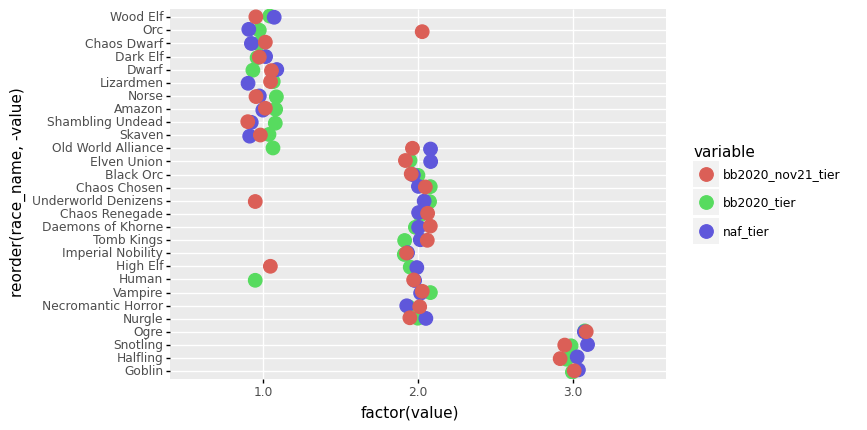

<ggplot: (-9223363264628860942)>

In [3]:
(p9.ggplot(data = race_tiers_long, mapping = p9.aes(x = 'reorder(race_name, -value)', y = 'factor(value)', group = 'variable', color = 'variable'))
    + p9.geom_jitter(size = 5, width = 0.1, height = 0.1) 
    + p9.coord_flip())
    

We can see that with the November 2021 rules update, Old World Alliance, Orcs and Humans have been "demoted" to tier 2, whereas High Elfs and Underworld Denizens have been promoted to tier 1.

Most NAF sanctioned tournaments use some form of tiering, but there exists a lot of variation in how this is implemented.
From the [rules for obtaining NAF sanctioning](https://www.thenaf.net/wp-content/uploads/2020/11/NAF_Tournament_Approval_Document_2021.pdf):

```
Individual rules variations in tournaments are permitted, even encouraged. This is in order to give each tournament its individual character.
[...]
Modifications should not radically affect the existing balance between races, but incentives may be given to the traditionally less-competitive teams, provided this is in moderation. 
```

For example, for the [World Cup in Austria (2019)](http://www.nafworldcup.sbbm-turniere.com/EN/WC4Rules.html), the Tier 2 teams above were further split up, giving four tiers in total. However, there are also tournaments (such as the [Dutch Open](https://sites.google.com/view/dutchopen/homepage?authuser=0) ) that directly use the official "GW Rulebook + Errata" tiers.

# Analyzing NAF data

Because there is all this variation in tiering rules for NAF tournaments, without taking into account to this information, it is difficult to draw conclusions from NAF match data. We can still see what we got though.

Here are the win rates (with a draw counted as half a point) for 10831 matches played at BB2020 NAF tournaments. These were taken from Mike Davies' [NAF Tableau pages](https://public.tableau.com/app/profile/mike.sann0638.davies/viz/NAFGames_0/Variety) and contain match outcomes of NAF tournaments between december 2020 and november 2021 using the new ruleset. 

I added uncertainty intervals assuming a simple "coin flip" process with a fixed probability of succes *p*, where i use for *p* the probability of succes that is calculated from the data. This gives us some indication of what variation to expect given the match volumes in the NAF database.

In [4]:
df_naf = pd.read_csv('data/W_Race_Record_Full_Data_dataBB2020nov.csv', na_values = '')

df_naf = df_naf.rename(columns={"Race": "race_name", 
                                "Variant": "ruleset_version", 
                                "Win %": "wins"})

# transform wins to 0, 0.5 or 1 numeric
df_naf['wins'] = df_naf['wins'].str.replace('%$', '')
df_naf['wins'] = df_naf['wins'].fillna(0).astype(float).astype(np.int64)
df_naf['wins'] = df_naf['wins']/100

# add tiers
df_naf = pd.merge(df_naf, race_tiers, on='race_name', how='left')

print("the NAF dataset contains", len(df_naf)/2, "match outcomes")

the NAF dataset contains 10831.0 match outcomes


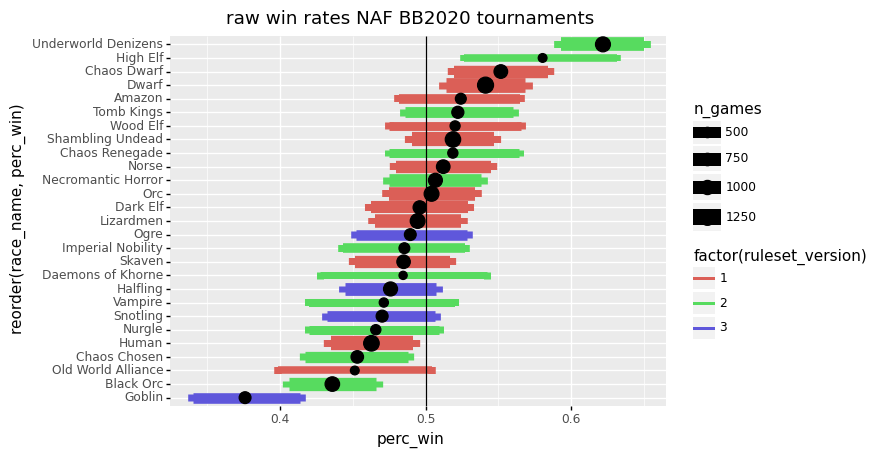

<ggplot: (-9223363264719130168)>

In [5]:
res = (df_naf
    .groupby(['race_name', 'ruleset_version', 'naf_tier', 'bb2020_nov21_tier', 'bb2020_tier'])
    .agg(        
        perc_win = ('wins', "mean"),
        n_wins = ('wins', "sum"),
        n_games = ('race_name', "count")
    )
    .sort_values( 'n_games', ascending = False)
    .reset_index()) # this adds the group by variables (now index) as a column

res = res.dropna()


res['lower_CI'], res['upper_CI'] =  proportion_confint(
                                      count = round(res['n_wins']).astype(int),
                                      nobs = res['n_games'],
                                      alpha = 0.05
                                  )

(p9.ggplot(data = res, mapping = p9.aes(x = 'reorder(race_name, perc_win)', y = 'perc_win', 
size = 'n_games', group = 'factor(ruleset_version)', color = 'factor(ruleset_version)'))
    + p9.geom_errorbar(p9.aes(ymin = 'lower_CI', ymax = 'upper_CI', color = 'factor(bb2020_tier)'))
    + p9.geom_point(colour = "black" )
    + p9.scale_size_area() 
    + p9.coord_flip()
    + p9.geom_hline(yintercept = 0.5)
    + p9.ggtitle("raw win rates NAF BB2020 tournaments"))


We can see that, even with most tournaments having some form of tiering, there are still teams that win (in) NAF tournaments more often than others, with Underworld Denizens standing out the most, and High Elves coming in second place. On the low end we have Humans and Old World Alliance, that win less than half of the time, despite being tier 1 according to the BB2020 rulebook. This likely explains the GW November 2021 changes made to their tiers mentioned above. The change of Orc tiering however is not explained by this data, as it has a win rate higher than several other tier 1 teams, such as Skaven, Lizardmen and Dark Elves. 

The October 2021 ["NAF tournament report"](https://www.thenaf.net/rankings/elo-ranking/tableau/the-naf-report-2/) by Mike Davies contains the following comment on the high win rate of Underworld Denizens:

```
Underworld continued to dominate in October, winning the two largest tournaments and maintaining the greater than 60% win ratio.  This is generally due to swarming giving them more players on the pitch and the use of Hakflem and Morg'n'Thorg. (N.b. these are special "Star Players" that can be added to teams)
```

So far for the NAF tournament data, let us move on to online Blood Bowl, let us move on to FUMBBL!

# Blood Bowl online: FUMBBL 

The **FUMBBL** website (https://fumbbl.com) contains a lot of data. From coach pages, with their teams, to team rosters, with players, and match histories. It's all there.
And the nice thing of **FUMBBL**, for our purpose, is that it has several divisions where all teams start out equal, with a budget of 1000K, and without any tiering system in place. I reasoned that this allows us to learn what the relative team strengths are purely under the official Blood Bowl rules, without any compensation mechanism to balance things out. However, as it turns out, we cannot simply generalize what we have learned to a tournament setting, because Tournaments work in a fundamentally different way (as described above). With this in mind, let us proceed.

We load the **FUMBBL** match outcome datasets that I have compiled and constructed, as documented in [a separate blog post](https://gsverhoeven.github.io/post/blood-bowl-fumbbl-dataset/).

In [6]:
# FUMBBL matches
target = 'data/df_matches_final.h5'
df_matches = pd.read_hdf(target) 

# FUMBBL matches by team
target = 'data/df_mbt_final.h5'
df_mbt = pd.read_hdf(target) 

# FUMBBL inducements
target = 'data/inducements_final.h5'
inducements = pd.read_hdf(target) 

# Weekly game volume on FUMBBL sept 2020 - nov 2021

Let's see what we've got! The pandas DataFrame `df_matches` contains records for all matches played on FUMBBL between sept 2020 and nov 2021.

Since we have a proper `datetime` type variable for each week (`week_date`), we can use `pandas` and `plotnine` to plot the weekly game volume as a time series.

The introduction of the new **Competitive division** with BB2020 rules is marked by a vertical red line.

In [7]:
res = (df_matches
    .loc[(df_matches['week_date'] >= '2020-09-01' ) & (df_matches['week_date'] < '2021-11-25')]
    .groupby(['week_date', 'week_number'])
    .agg(        
        n_games = ('match_id', "count") 
    )
    .reset_index()) # this adds the "group by" variables back as columns of res


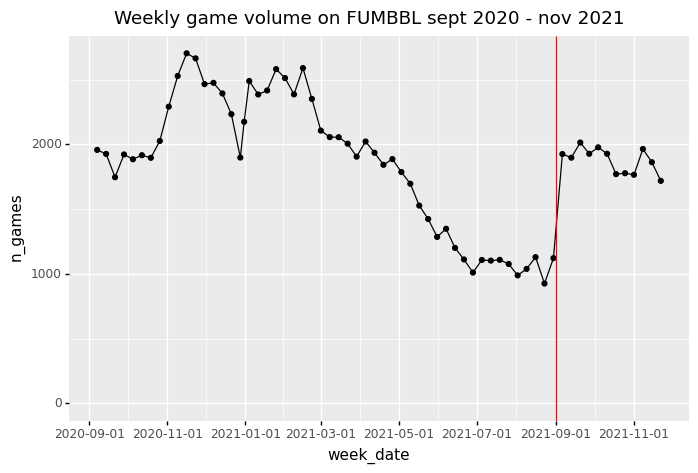

<ggplot: (-9223363264789314602)>

In [8]:
(p9.ggplot(data = res, mapping = p9.aes(x = 'week_date', y = 'n_games', group = '1'))
    + p9.geom_point() 
    + p9.geom_line()
    + p9.expand_limits(y=[0,2000])
    + p9.geom_vline(xintercept = '2021-09-01', color = "red")
    + p9.theme(figure_size = (8, 5))
    + p9.ggtitle("Weekly game volume on FUMBBL sept 2020 - nov 2021"))



To check the dataset, I compared this plot with the plot of weekly game volumes that FUMBBL itself provides at https://fumbbl.com/p/stats.
Both plots looked identical at the time of writing, so it seems that we have a complete dataset for the given period.

The effect of starting the new BB2020 Competitive division is clearly visible, with the weekly game volume almost doubling in september 2021.

# What are the most commonly used inducements in BB2020 Tournaments?

For this, the only available data we have is the FUMBBL NAF online tournament from last october, "The Good, the Bad, the Fair and the Ugly".
This was for 91 squads of four coaches competing for 6 rounds, giving a total of roughly 1000 matches.

Lets plot the most commonly used inducements in this tournament:


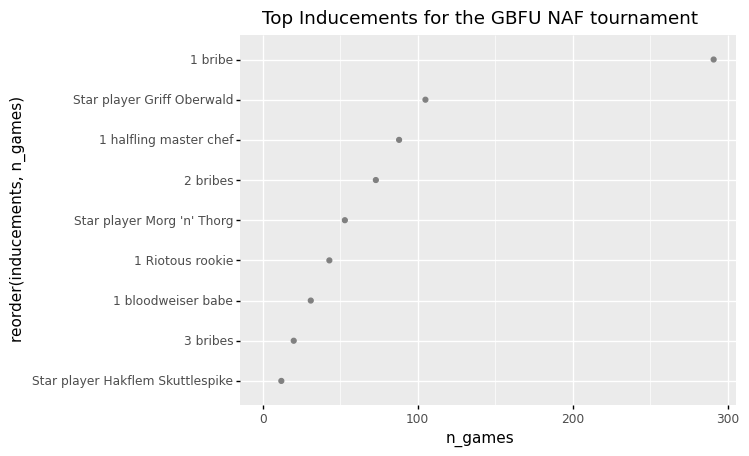

<ggplot: (8772065367714)>

In [9]:
gbfu_matches = df_matches.query("division_name == 'NAF' & ruleset == 2228 & match_date > '2021-09-01'")['match_id']

# aggregate by race_name
res = (inducements[inducements['match_id'].isin(gbfu_matches)]
        .query("inducements != ''")
        .groupby(['inducements', 'star_player', 'special_card'])
        .agg(
                n_games = ('inducements', "count")
        )
        .reset_index()
        .sort_values("n_games", ascending=False)
)

(p9.ggplot(data = res.query("n_games > 10"), mapping = p9.aes(x = 'reorder(inducements, n_games)', y = 'n_games'))
    + p9.geom_point(colour = 'gray') 
    + p9.expand_limits(y = 0)
    + p9.coord_flip()
    + p9.ggtitle('Top Inducements for the GBFU NAF tournament'))

In the GBFU NAF tournament, we see that in some 150 matches either Griff, Morg or Haklem were fielded.
Checking the matches with Griff, we find that its mostly Halfling and Ogre teams that field him. This is likely related to the budget constraint of 1150K.
Hakflem was chosen on the Snotling teams, Snotling, Halfling and Goblin teams had Morg 'n' Thorg. This strategy is called "min TV + Star player".

In [10]:
morg_matches = inducements[inducements['match_id'].isin(gbfu_matches)].query('inducements == "Star player Morg \'n\' Thorg"')['match_id']

In [11]:
df_matches.query("match_id in @morg_matches").shape

(53, 40)

# Star player usage across divisions and leagues, over time

An interesting "marker" to compare tournaments / divisions is to look at the percentage of matches that involve star players.
This is also related to variation in team strength within a division, as this is one of the mechanisms that allows inducing them.
For example, When the Competitive division started out, all teams start with 1000K. So initially, no Star players could be induced.

In [12]:
divisions = ['Blackbox', 'Competitive', 'NAF',  'Ranked', 'Regular_league']

res = (df_matches
.query("division_name in @divisions")
.groupby(['division_name', 'league', 'ruleset', 'ruleset_version', 'week_date'])
.agg(
    n_games = ('match_id', 'count'),
    perc_sp = ('has_sp', 'mean')
)
.reset_index()
.sort_values("n_games", ascending=False)
)


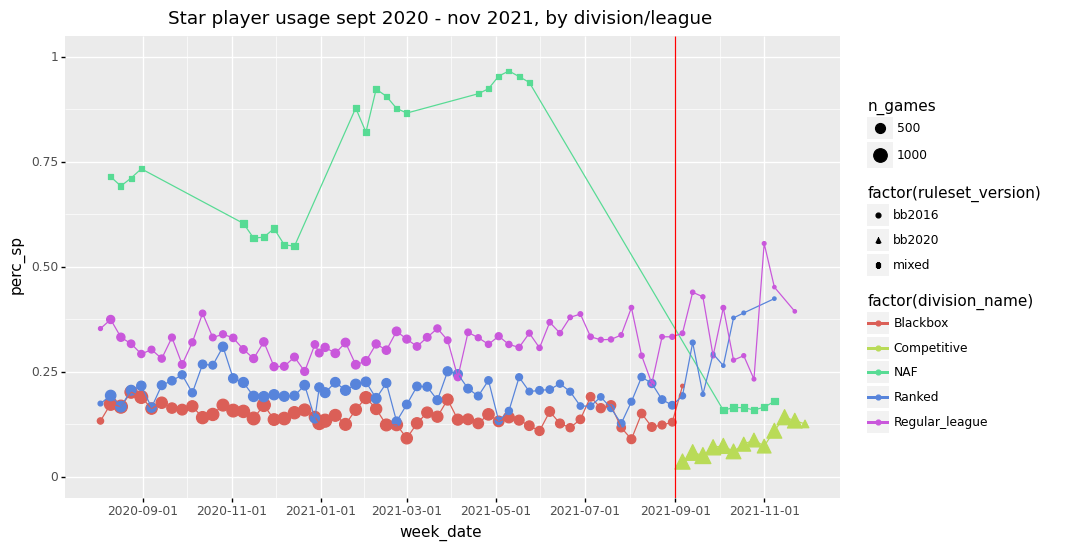

<ggplot: (8772080047238)>

In [13]:
(p9.ggplot(data = res.query("n_games > 30"), mapping = p9.aes(x = 'week_date', y = 'perc_sp', 
group = 'factor(division_name)', color = 'factor(division_name)'))
    + p9.geom_point(p9.aes(shape = 'factor(ruleset_version)', size = 'n_games')) 
    + p9.geom_line()
    + p9.expand_limits(y=[0,1])
    + p9.scale_size_area()
    + p9.geom_vline(xintercept = '2021-09-01', color = "red")
    + p9.ggtitle("Star player usage sept 2020 - nov 2021, by division/league")
    + p9.theme(figure_size = (10, 6)))

In above graph, the various online NAF Tournaments in 2020/2021 are clearly distinguished. Amorical Cup 2020 in summer 2020, Eur'Open Online in Nov/dec 2020, SteelBowl in Feb 2021, And LitBowl in May 2021. Through Googling and using the Wayback Machine, I was able to find the rulepacks of these tournaments.  LitBowl featured "big budgets" (up to 1440K) and a requirement of only 10 regular players before inducement, this likely explains the large amount of Star Players in that tournament.  In contrast, in the GBFU tourney, oct 2021 only some 15% of matches involved at least one star player. 

There is already quite some variation in rulepacks for these four tournaments:  They differ with respect to individuals vs squads that compete, restrictions on the team choices of the squad as a whole (Amorical Cup, GBFU), starting budget, weighting of outcomes (2:1:0, 5:2:0) etc. 

# Selecting the divisions and leagues to analyse

FUMBBL allows coaches to create their own rulesets to play their own leagues and tournaments with. For example, there is a so-called "Secret League" where coaches can play with "Ninja halflings", of with "Ethereal" spirits etc. 

Since we want the team strength for the official rulesets BB2016 and BB2020, we need to drop the matches that are played under different rules.

Lets have look at the main divisions and leagues on FUMBBL, and the match volume in the dataset for each of those.

To get sufficient observations for all the 25+ teams, we need sufficient match volume, so we select only leagues / divisions with more than 1000 matches in the dataset.



In [14]:
main_divisions = (df_matches
    .groupby(['ruleset', 'league', 'division_id', 'division_name',  'ruleset_version'], dropna=False)
    .agg( 
        n_matches = ('ruleset', 'count')
    )
    .sort_values('n_matches', ascending = False)
    .query('n_matches > 1000')['n_matches']
    .reset_index()
)

main_divisions

,ruleset,league,division_id,division_name,ruleset_version,n_matches
0,1,0,10,Blackbox,bb2016,36274
1,1,0,1,Ranked,bb2016,21428
2,4,0,2,Competitive,bb2020,15003
3,6,0,5,Regular_league,bb2016,13362
4,303,10263,5,Secret League,bb2016,5283
5,2228,9298,5,NAF,mixed,3861
6,432,10455,5,CIBBL,bb2016,2079


In [15]:
res = (df_matches
    .loc[(df_matches['week_date'] >= '2020-09-01' ) & (df_matches['week_date'] < '2021-11-25') & df_matches['division_name'].isin(main_divisions['division_name'])]
    .groupby(['division_name', 'ruleset_version', 'week_date', 'year'])
    .agg(        
        n_games = ('match_id', "count")
    )
    .reset_index()) # this adds the group by variables (now index) as a column


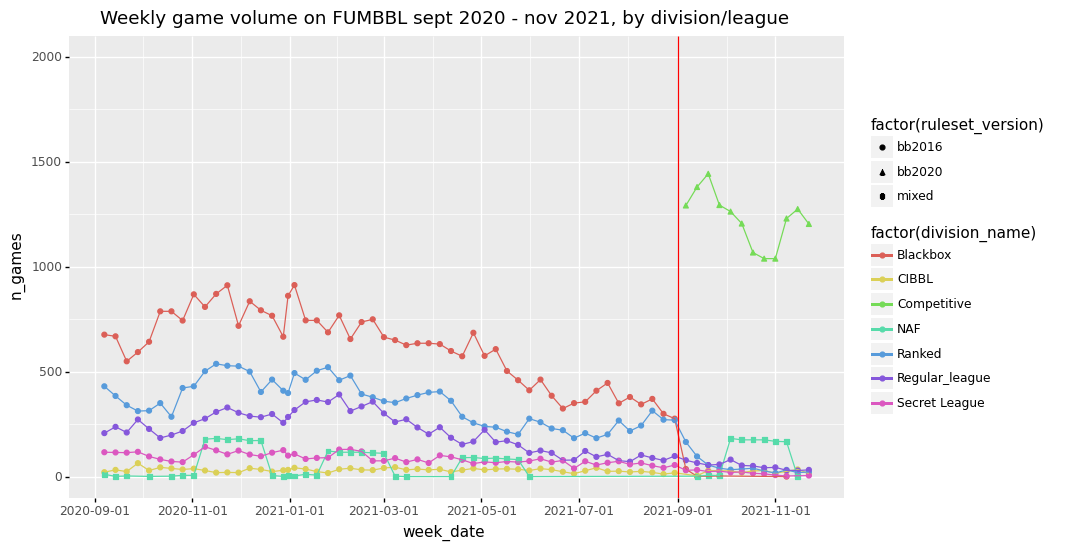

<ggplot: (-9223363264774567613)>

In [16]:
(p9.ggplot(data = res, mapping = p9.aes(x = 'week_date', y = 'n_games', 
group = 'factor(division_name)', color = 'factor(division_name)'))
    + p9.geom_point(p9.aes(shape = 'factor(ruleset_version)')) 
    + p9.geom_line()
    + p9.expand_limits(y=[0,2000])
    + p9.geom_vline(xintercept = '2021-09-01', color = "red")
    + p9.ggtitle("Weekly game volume on FUMBBL sept 2020 - nov 2021, by division/league")
    + p9.theme(figure_size = (10, 6)))


We are interested in comparing BB2020 with the previous ruleset, BB2016. At the time of writing, the only division with sufficient BB2020 match volume is the **Competitive** division, with [ruleset 4](https://fumbbl.com/p/ruleset?id=4). 

For the BB2016-based rulesets, the plot shows three popular FUMBBL divisions: Blackbox, Ranked and (regular) League.

Blackbox and Ranked use [ruleset 1](https://fumbbl.com/p/ruleset?id=1), whereas the regular League uses [ruleset 6](https://fumbbl.com/p/ruleset?id=6). 

Comparing both rulesets, we find that both are based on the BB2016 ruleset, but there are a few differences: e.g. League has a few "unofficial" teams available (e.g. Slann, Simyin), allows for special play cards,  but does not allow  wizards and does not the use the expensive mistakes rule. 

So for the rest of this blog post, we focus on these four divisions:

* Ranked division (BB2016)
* Blackbox division (BB2016)
* standard League division (BB2016)
* Competitive division (BB2020)

If the differences between the three BB2016 divisions can be considered small, we can pool the matches from these three leagues to get better statistics.

So lets first compare win rates between these three divisions.

If we want to calculate a win rate for each race, we need to decide what to do with draws.

# Match outcomes: How much is a draw worth?

So, if we want to predict which teams perform best in tournaments (i.e. has the highest probability of winning a tournament), ideally, we need to weigh the match outcomes as their weighted in those tournaments. 

In football, there is a popular weighting scheme where wins are given 3 points, draws 1 point and losses 0 points.
This is called [three points for a win](https://en.wikipedia.org/wiki/Three_points_for_a_win) . 
In Blood bowl leagues and tournaments, this rule is often used as well.
However, apparently, A 2:1:0 weighting scheme is also used, for example in the Eur'Open Online 2020.

In Blood Bowl data analysis, it seems that a 2:1:0 (W / D / L) weighting scheme is most commonly used. 
For example, Mike Davies from the NAF calculates win rate by weighting each win as 1 point, and each draw as 0.5 points (For example, [here](https://public.tableau.com/app/profile/mike.sann0638.davies/viz/NAFGames_0/SuccessBB2020)).

This scheme has the advantage that the average win percentage over all matches is always 50%.
This creating a nice reference point, allowing conclusions such as "this and that team has an x percent above average win percentage".

Given the practical advantages of this weighting scheme, we adopt it here as well.

# FUMBBL Coach ratings

**PM rewrite this part**
If we want to learn about differences in team strength, we need to take into account differences in coach strength.

Correlation is not causation, as the saying goes.

If the more experienced coaches know which teams are strongest, and choose those teams more often, we will see high win rates for those teams.

If a team is more difficult to coach succesfully, inexperienced coaches picking such a team pull the winning rate down. On the other hand, they might be less tempted to pick the team, whereas experienced coaches might be attracted to the team, pulling the winning rate up.

So, if experienced coaches have different preferences for teams, compared to inexperienced coaches, this will influence win rates.
The win rates we now attribute to differences in innate race strength, might be caused by the unobserved abilities of the coaches playing.

We want coach rating difference bins, and count outcomes within each bin.

First we check if the Coach ratings are predictive.

According to the elo ranking system, a coach rating difference of 40 should result in 85% wins for the higher ranked coach.
Coaches of equal rating should have a win rate of 0.5 (with draws weighted at half point).

Since our CR is an overall coach rating, that ignores division, we can simply select all divisions where coach rating is tracked.

In [17]:
main_divisions = ['Blackbox', 'Ranked', 'Competitive'] 
res = (df_matches[df_matches['division_name'].isin(main_divisions)]
    .groupby(['cr_bin', 'team1_win'])
    .agg(        
        n_games = ('cr_bin', "count"),
        avg_CR_diff = ('cr_diff2', "mean")
    )
    .reset_index()) # this adds the group by variable (now index) as a column

In [18]:
res['n_games_bin'] = res.groupby('cr_bin').n_games.transform('sum')

res['perc'] = res['n_games']/res['n_games_bin']


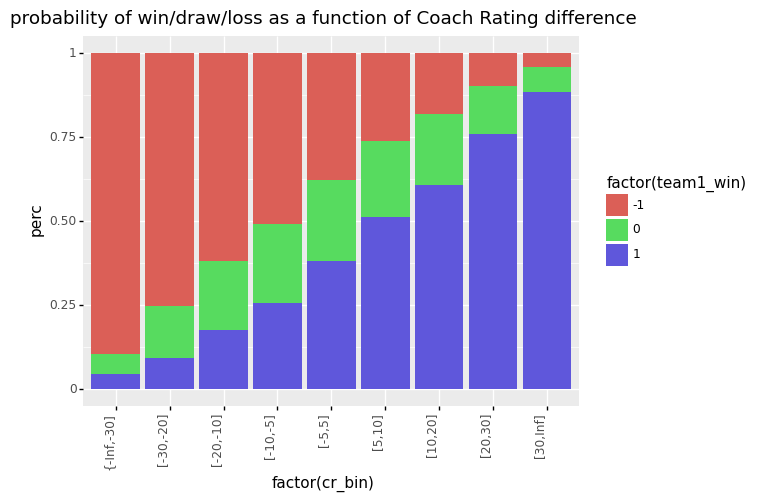

<ggplot: (-9223363264774565614)>

In [19]:
(p9.ggplot(res, p9.aes(x = 'factor(cr_bin)', y = 'perc', fill = 'factor(team1_win)')) 
    + p9.geom_bar(position = "fill", stat = "identity") 
    + p9.theme(axis_text_x= p9.element_text(rotation=90, hjust=1))
    + p9.ggtitle('probability of win/draw/loss as a function of Coach Rating difference')
)

In [20]:
df_mbt.query("match_id == 4347799")

,match_id,match_date,week_number,year,week_year,week_date,team_id,coach_id,race_name,team_value,wins,tv_diff,tv_match,tv_bin,mirror_match,coach_CR,CR_diff,has_sp,division_id,division_name,league,ruleset,roster_id,games_played,roster_name,ruleset_version,bb2020_tier,naf_tier,bb2020_nov21_tier
1,4347799,2021-11-30,48,2021,2021-48,2021-11-29,1042263.0,255911.0,Lizardmen,1260,1.0,130,1260,1.4K,0,154.60,3.48,0.0,2,Competitive,0,4,4966,6,4966_Lizardmen,bb2020,1.0,1.0,1.0
131510,4347799,2021-11-30,48,2021,2021-48,2021-11-29,1044174.0,248304.0,Vampire,1130,0.0,130,1260,1.4K,0,151.12,3.48,0.0,2,Competitive,0,4,5146,116,5146_Vampire,bb2020,2.0,2.0,2.0


The coach ratings work as expected (on average) in predicting match outcomes.
For more details see Christer's descriptions here and here.

# Coach ranking vs win percentage

So which coach is the best? Naively, we would simply calculate the average win percentage.
If a coach wins more, he must be better, right? Not so fast, this depends of course against whom the coach plays.
Coaches that play more games against experienced players tend to lose more.

It is therefore interesting to compare the Coach rankings and coach win percentages.
The CRs are global rankings, that ignore division, or team race.
The CR is the value **Before** the match, in parentheses is the CR update. This gives us the CR used for the next match.

**PM because we have a global CR this is a really complicated plot**
In Ranked, it is thought that coaches can cherry pick, and BB they cannot


In [21]:
main_divisions = ['Blackbox', 'Ranked','Competitive']

res = (df_mbt[df_mbt['division_name'].isin(main_divisions)]
    .groupby(['coach_id', 'division_name'])
    .agg(        
        perc_win = ('wins', "mean"),
        n_wins = ('wins', "sum"),
        n_games = ('race_name', "count"),
        avg_CR = ('coach_CR', "mean")
    )
    .query('n_games > 100')
    .sort_values('perc_win', ascending = False)
    .reset_index()) # this adds the group by variable (now index) as a column

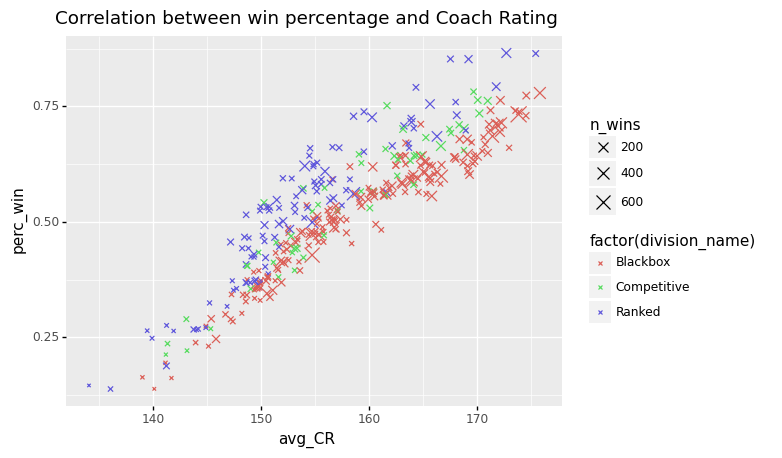

<ggplot: (8772080300008)>

In [22]:
(p9.ggplot(data = res, mapping = p9.aes(x = 'perc_win', y = 'avg_CR', size = 'n_wins', colour = 'factor(division_name)'))
    + p9.geom_point(shape = 'x') 
    + p9.scale_size_area()
    + p9.coord_flip()
    + p9.ggtitle('Correlation between win percentage and Coach Rating'))


Here we can see that in a given environment, there appears a relatively tight relationship between average CR over all the matches played, and the average win percentage. We also see that the best coaches have average win rates of > 75%, a fact that is often used as evidence that although luck is involved in Blood Bowl, the outcome of a match definitely involves skill.

Interestingly, we see that in Blackbox, indeed the average win rates are lower for a given coach ranking.

# Comparing the three BB2016 FUMBBL divisions

Here we compare the BB2016 divisions. Do we expect similar win probabilities for the different team races?
Or are there differences that are important for our comparison?

For example, in the `Blackbox` division, coaches are randomly matches, so they have less control over which opponent they play.
Whereas in the `Ranked` division, both coaches need to agree before the match takes place, so they can more or less choose their opponent, possibly avoiding particular team races.

According to the description on FUMBBL, League is a "Non-competitive division used for player-run tournaments and leagues".
Whereas Blackbox and Ranked are competitive divisions, one randomized and one with open play.
Another difference is that only for Blackbox and Ranked, Coach Ratings are available.

Beforehand, we expect that teams in the Blackbox and Ranked divisions have played more games on average, and are therefore more developed (have higher team value).


So, we compare **games played** distributions of the teams in each match between the three divisions, to learn a bit more about possible differences.
I filtered on teams with less than 500 games played, and use box plots to focus on the range where most of the data in concentrated (the box containts 50% of the data).

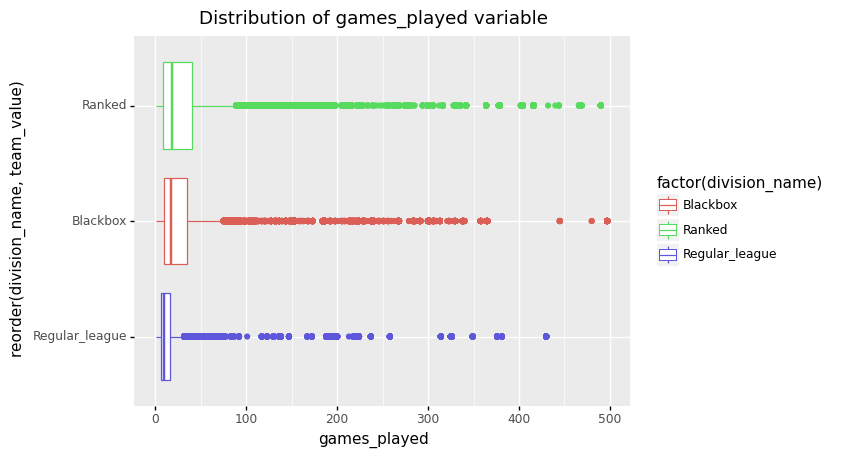

<ggplot: (8772080422485)>

In [23]:
bb2016_divisions = ['Ranked', 'Regular_league', 'Blackbox']

(p9.ggplot(data = df_mbt[df_mbt['division_name'].isin(bb2016_divisions)].query("games_played < 500"), mapping = p9.aes(x = 'reorder(division_name, team_value)', y = 'games_played', 
group = 'factor(division_name)', color = 'factor(division_name)'))
    + p9.geom_boxplot()
    #+ p9.scale_size_area() 
    + p9.coord_flip()
    + p9.ggtitle("Distribution of games_played variable"))

This makes sense, as people tend to play longer with teams outside of leagues / tournaments, which force redrafts and / or are limited in duration.



# Comparing win rates of the three BB2016 divisions with similar TV

In [24]:
bb2016_divisions = ['Ranked', 'Blackbox', 'Regular_league']

tv_bins = ['1.1K', '1.4K', '1.7K']

res = (df_mbt[df_mbt['division_name'].isin(bb2016_divisions)]
    .loc[df_mbt['tv_bin'].isin(tv_bins)]
    .query("mirror_match == 0 & has_sp == 0 & tv_bin in @tv_bins & division_name in @bb2016_divisions")
    .groupby(['division_name', 'ruleset_version', 'race_name', 'tv_bin'])
    .agg(        
        perc_win = ('wins', "mean"),
        n_wins = ('wins', "sum"),
        n_games = ('race_name', "count")
    )
    .sort_values( 'n_games', ascending = False)
    .reset_index()) # this adds the group by variables (now index) as a column

res = res.dropna()

In [25]:
df_mbt.query('race_name == "Amazon" & division_name == "Regular_league" & tv_bin == "1.1K" & mirror_match == 0')['has_sp'].value_counts()

0.0    309
1.0     42
Name: has_sp, dtype: int64

In [26]:
import statsmodels.api as sm
# Function for computing confidence intervals
from statsmodels.stats.proportion import proportion_confint   

res['lower_CI'], res['upper_CI'] =  proportion_confint(
                                      count = round(res['n_wins']).astype(int),
                                      nobs = res['n_games'],
                                      alpha = 0.05
                                  )

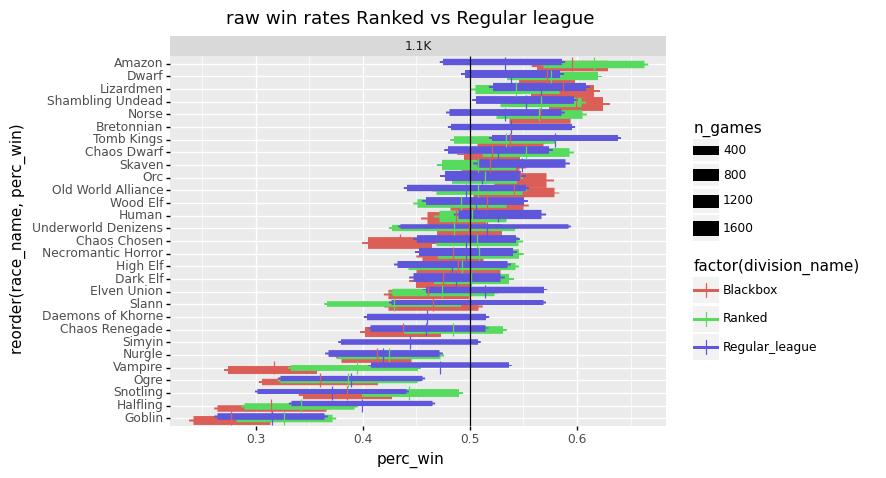

<ggplot: (8772065358393)>

In [27]:
(p9.ggplot(data = res.query('n_games > 10 & tv_bin == "1.1K"'), mapping = p9.aes(x = 'reorder(race_name, perc_win)', y = 'perc_win', 
size = 'n_games', group = 'factor(division_name)', color = 'factor(division_name)'))
    + p9.geom_errorbar(p9.aes(ymin = 'lower_CI', ymax = 'upper_CI'), position=p9.position_dodge2(preserve='single'))
    + p9.geom_point(shape = '|', size = 5) # color = 'black', 
    + p9.facet_wrap('tv_bin')
    + p9.scale_size_area() 
    + p9.coord_flip()
    + p9.geom_hline(yintercept = 0.5)
    + p9.ggtitle("raw win rates Ranked vs Regular league"))

In [28]:
#df_mbt.query('tv_bin == "1.1K" & division_name == "Regular_league" & race_name == "Amazon" & mirror_match == 0')

So, if we compare Ranked vs regular league **within Team value bins**, no clear substantial differences appear.
This suggests we can pool both leagues and compare both to the Competitive BB2020 match results.
As long as we use team value bins, like "Taureau Amiral".

Comparing the win rates of BB2016 and BB2020 to koadah's dataset on http://fumbbldata.azurewebsites.net/stats.html , we find strong agreement.


*Conclusions for Ranked vs Black box*
For the lower tier teams Ogre, Halfling and Goblin, clear differences can be seen between Ranked and Blackbox. Black box performance is lower.
This suggests that we see the effect of strategically avoiding certain opponents, which is not possible in Blackbox. 

This argument could also explain the lower performance of Amazon at higher TV, which are known to perform better at low TV.
For Chaos Chosen, we see a pattern that could be explained if players in Ranked strategically choose their opponents to skill up the team, which is known to only become competitive at higher team value.

This gives some strength to the argument that the Competitive Division is not a **truly** competitive division, since players can choose their opponents, which is not possible at tournaments, and at random matching environments such as Blackbox was.



# Main analysis: win rate BB2016 vs BB2020

We are going to do the comparison for the main **competitive** divisions that use BB2016 and BB2020 rules.
The BB2016 rules are in two competitive divisions: Blackbox and Ranked.

We drop so-called **mirror matches** (a small percentage of matches) where for example Orcs play Orcs.

We also restrict the analysis to matches **without Star Players**. This way, we can exclude that the win rate was influenced by popular Star Players such as Hakflem, Morg or Griff.

AND, we also restrict ourself to matches where the coach difference is small (less than 5), so that we can with more confidence attribute the outcome to the races, and not to the ability of the coach.

Finally, we subset on coaches with CR > 150, the idea is that some teams need more experience to play well, and we expect more experienced coaches to have higher CR as well.



In [29]:
main_divisions = ['Blackbox', 'Ranked', 'Competitive']

res = (df_mbt[df_mbt['division_name'].isin(main_divisions)]
    .query('mirror_match == 0 & has_sp == 0 & CR_diff < 5 & coach_CR > 150')
    .groupby(['race_name', 'ruleset_version', 'bb2020_nov21_tier', 'naf_tier', 'tv_bin'])
    .agg(        
        perc_win = ('wins', "mean"),
        n_wins = ('wins', "sum"),
        n_games = ('race_name', "count")
    )
    .query('n_games > 0')
    .reset_index()) # this adds the group by variable (now index) as a column


In [30]:
res['lower_CI'], res['upper_CI'] =  proportion_confint(
                                      count = round(res['n_wins']).astype(int),
                                      nobs = res['n_games'],
                                      alpha = 0.05
                                  )


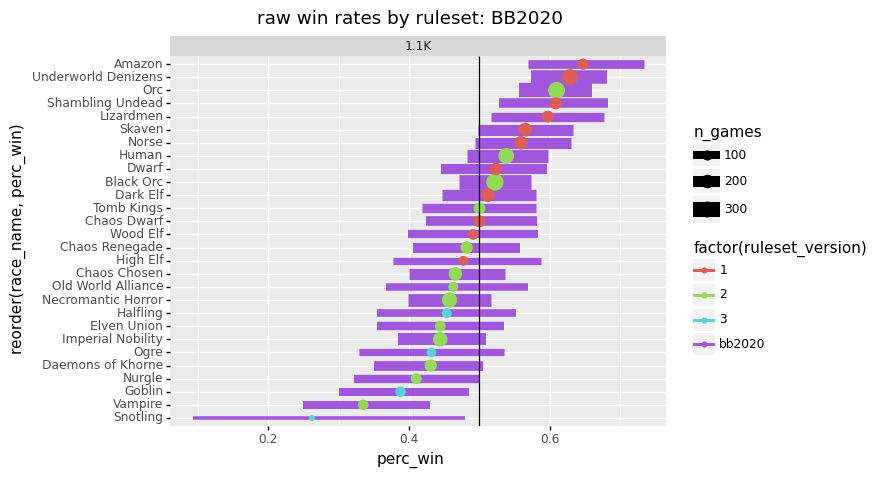

<ggplot: (-9223363264774127395)>

In [31]:

(p9.ggplot(data = res.query('n_games > 10 & tv_bin == "1.1K" & ruleset_version == "bb2020" '), mapping = p9.aes(x = 'reorder(race_name, perc_win)', y = 'perc_win', 
size = 'n_games', group = 'factor(ruleset_version)', color = 'factor(ruleset_version)'))
    + p9.geom_linerange(p9.aes(ymin = 'lower_CI', ymax = 'upper_CI'))
    + p9.geom_point(p9.aes(color = 'factor(bb2020_nov21_tier)') )
    + p9.facet_wrap('tv_bin')
    + p9.scale_size_area() 
    + p9.coord_flip()
    + p9.geom_hline(yintercept = 0.5)
    + p9.ggtitle("raw win rates by ruleset: BB2020"))

So main findings regarding tiering in BB2020: Orcs are definitely tier 1. Underworld Denizens have become one of the strongest teams and are tier 1. Vampires would more appriately be tier 3. Old World Alliance tier 2 looks right. High Elf tier 1 is little evidence for it.


When interpreting these results, we should keep in mind that this is at low Team value, for example starting rosters, without any tiering.

First, we check out the new teams introduced in BB2020. Both teams, Imperial nobility and Black orcs, are not the strongest teams around with win rates that are below average.

In Tier 1, Amazons and Orcs improved substantially. 
Surprisingly, Underworld denizens are now among the strongest teams around. 

In Tier 2, Old World Alliance got substantially worse. There is no evidence for a higher win rate for High Elves, as was observed in the NAF tournament data of 2021.

In Tier 3, Halflings and goblins improved. 


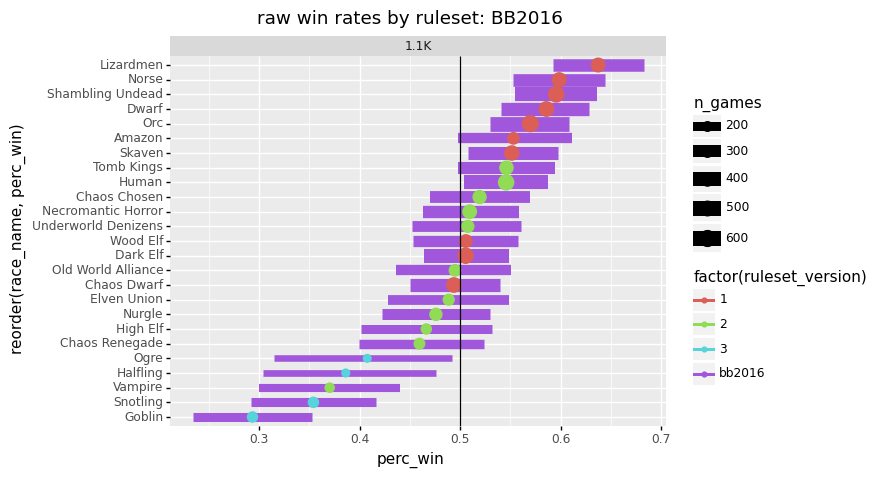

<ggplot: (8772080803157)>

In [32]:

(p9.ggplot(data = res.query('n_games > 10 & tv_bin == "1.1K" & ruleset_version == "bb2016" '), mapping = p9.aes(x = 'reorder(race_name, perc_win)', y = 'perc_win', 
size = 'n_games', group = 'factor(ruleset_version)', color = 'factor(ruleset_version)'))
    + p9.geom_linerange(p9.aes(ymin = 'lower_CI', ymax = 'upper_CI'))
    + p9.geom_point(p9.aes(color = 'factor(naf_tier)') )
    + p9.facet_wrap('tv_bin')
    + p9.scale_size_area() 
    + p9.coord_flip()
    + p9.geom_hline(yintercept = 0.5)
    + p9.ggtitle("raw win rates by ruleset: BB2016"))

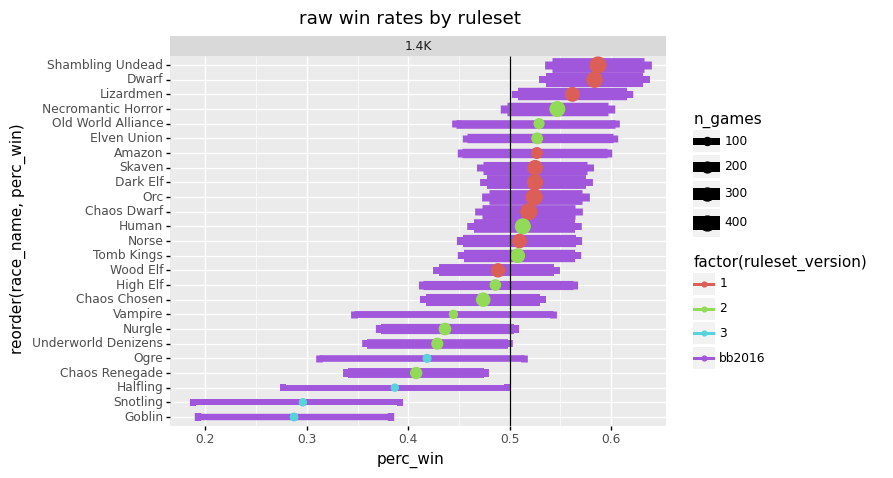

<ggplot: (-9223363264773846563)>

In [33]:

(p9.ggplot(data = res.query('n_games > 10 & tv_bin == "1.4K" & ruleset_version == "bb2016" '), mapping = p9.aes(x = 'reorder(race_name, perc_win)', y = 'perc_win', 
size = 'n_games', group = 'factor(ruleset_version)', color = 'factor(ruleset_version)'))
    + p9.geom_errorbar(p9.aes(ymin = 'lower_CI', ymax = 'upper_CI'))
    + p9.geom_point(p9.aes(color = 'factor(naf_tier)') )
    + p9.facet_wrap('tv_bin')
    + p9.scale_size_area() 
    + p9.coord_flip()
    + p9.geom_hline(yintercept = 0.5)
    + p9.ggtitle("raw win rates by ruleset"))

At higher TV, the uncertainty is larger, as less teams "make it" to higher team values. Because it takes time, and the data is from the first three months of BB2020 play, and it takes energy (you can lose a few games, and have to recover from that).

The clearest changes at medium team value (around 1.4K +/-150) are improvements for Goblins and for Underworld Denizens. For goblins, the typical inducement is bribes. Even with 150K team value, 3 bribes are often induced, instead of a star player. 
Both new BB2020 teams, Imperial Nobility and Black Orcs, appear to be below average strength teams.

# Do star players contribute to the success of Underworld denizens on FUMBBL?

According to various NAF tournament reports, having access to Star players such as Hakflem and Morg 'n Thorg contributed to the succcess of Underworld Denizens in last years BB2020 tournaments. Hakflem appears to be very good value for money: In BB2020, Hakflem can be induced for 180K, whereas his roster value is estimated at 220K (according to this [article in Grotty Little Newspaper](https://fumbbl.com/modules.php?op=modload&name=Sections&file=index&req=viewarticle&artid=26&page=8) (from August 28th 2511 :-)).

Now, since the FUMBBL data is not in a tournament setting, we cannot do a proper comparison. Most tournaments are "resurrection", so that casualties (Miss next game) do not carry over to the next game. To be able to field haklem on FUMBBL coaches either need to play "up", with a team value difference of at least 180K (this is relatively rare), or keep team value below 800K. Different UW starting rosters for BB2020 are summarised nicely [on bbtactics.com](https://bbtactics.com/bb2020-underworld-denizens-starting-rosters/) ).

It turns out that only a handful FUMBBL matches (49 out of 1635) involve UW having a team value difference sufficient to induce Haklem (180K, this was before the recent price increase to 210K).


In [34]:
 match_selection = df_mbt.query("race_name == 'Underworld Denizens' & division_name == 'Competitive'")['match_id']

 df_matches.query("match_id in @match_selection").shape

(1635, 40)

In [35]:
 match_selection = df_mbt.query("race_name == 'Underworld Denizens' & division_name == 'Competitive' & team_value < tv_match & tv_diff > 170")['match_id']

 df_matches.query("match_id in @match_selection").shape

(49, 40)

In the FUMBBL competitive environment, the majority of games played with UWD are played either without inducements, or with bribes or bloodweiser kegs. So the above average win rate we see for this team in FUMBBL is likely caused by the rule changes to the team itself.

# Conclusions

The idea 
Nevertheless, it is striking that the win rates more or less following the tiers.
For the teams that already existed in BB2016, there were a few notable changes in relative team strength.

[...]


PM New NAF FUMBBL tournament with 5 tiers, skill stacking etc.

And check out this ruleset: Project "all teams viable". The idea behind this ruleset is to make all teams competitive - while trying to maintain balance.
https://www.bloodbowl.dk/atv-no-stars/

Recently, GW published the november 2021 errata, including changes in the tiering system.
The underworld denizens were nerfed by changing the swarming rule. Also star players Hakflem and Morg became more expensive. And finally, the UW team was promoted to tier 1. Surprisingly, Orcs were demoted to tier 2, and High elves promoted to tier 1. These changes appear unjustified based on the analysis presented here. Motivation for doing so was because tournament performance was not according to their tier. It might be that this is partly based on the NAF tournaments reproduced above. I looked up a tournament where High Elf won (**FirenzeGiocaBlitz**), and there High Elf was placed in the 5th of 7 tiers. So that might have contributed to the win.


https://www.bloodbowl.dk/atv-no-stars/

Tier 0 – 36 SPPs

    Dark Elves, Dwarves, Lizardmen, Shambling Undead, Wood Elves

Tier 1 – 42 SPPs

    Amazon, Chaos Dwarf, Necromantic, Orcs, Underworld Denizens

Tier 2 – 48 SPPs

     Elven Union, Human, Khorne, Norse, Skaven

Tier 3 – 54 SPPs

    Chaos Chosen, Chaos Renegades, High Elves, Imperial nobility, Khemri Tomb Kings, Old World Alliance, Slann

Tier 4 – 60 SPPs

    Black Orc, Daemons of Khorne, Nurgle, Vampires

Tier 5 – 66 SPPs

    Goblins, Halflings, Ogres, Snotling



Tiers for Eur'Open 2020 Nov

Tier 1
100k
• Amazons • Dark Elves • Dwarves • Lizardmen • Norse • Wood Elves • Undead •

Tier 2
120k
• Chaos Dwarves • Orcs • Skaven • Necromantic • Old World Alliance •

Tier 3
140k
• Bretonnians • Humans • Chaos •

Tier 4
170k
• Chaos Renegades • Elf Union • High Elves • Khemri • Nurgle • Slann •

Tier 5
200k
• Daemons of Khorne • Underworld Denizens • Vampires •

Tier 6
230k
• Goblins • Halfings • Ogres • Snotlings •


# BB2016 Race vs race win rates at low TV

For BB2016, we have enough matches to split out race vs race win rates.
We need roughly a thousand matches for each race combo / Team value bin to get sufficiently accurate statistics, and not all races are as popular.
We can only get to these numbers if we pool all three BB2016 divisions together.

In [36]:
from copy import copy
races = df_mbt.query("division_name in @main_divisions").race_name.unique()
# do all top tier races
cnt = 0
fullrun = 0

if fullrun:
    for race1 in races:
        for race2 in races:
            #print(race1, 'vs', race2)
            match_selection = df_matches.query("((team1_race_name == @race1 & team2_race_name == @race2) | (team2_race_name == @race1 & team1_race_name == @race2)) & division_name in @main_divisions")['match_id']

            res = (df_mbt
                .query('has_sp == 0 & match_id in @match_selection & race_name == @race1')
                .groupby(['race_name', 'ruleset_version', 'bb2020_nov21_tier', 'naf_tier', 'tv_bin'])
                .agg(        
                    perc_win = ('wins', "mean"),
                    n_wins = ('wins', "sum"),
                    n_games = ('race_name', "count")
                )
                .query('n_games > 0')
                .reset_index()
            )
            res['race1_name'] = race1
            res['race2_name'] = race2
            if cnt == 0:
                df_pairs = copy(res)
            else:
                df_pairs = pd.concat([df_pairs, res])
            cnt += 1
            #print(df_pairs)
    df_pairs.to_hdf('data/df_pairs.h5', key = 'df_pairs', mode = 'w', format = 't', complevel = 9)
else:
    df_pairs = pd.read_hdf('data/df_pairs.h5')



In [37]:
df_pairs['lower_CI'], df_pairs['upper_CI'] =  proportion_confint(
                                      count = round(df_pairs['n_wins']).astype(int),
                                      nobs = df_pairs['n_games'],
                                      alpha = 0.05
                                  )

#df_pairs                                  

In [62]:
df_pairs['contains_05'] = 1

query = "lower_CI > 0.5 | upper_CI < 0.5"

df_pairs.loc[df_pairs.eval(query), 'contains_05'] = 0

In [63]:
df_pairs.query("contains_05 == 0")

,race_name,ruleset_version,bb2020_nov21_tier,naf_tier,tv_bin,perc_win,n_wins,n_games,race1_name,race2_name,lower_CI,upper_CI,contains_0.5,contains_05
2,Shambling Undead,bb2016,1.0,1.0,1.7K,0.663462,34.5,52,Shambling Undead,Lizardmen,0.524540,0.783152,0,0
6,Shambling Undead,bb2020,1.0,1.0,1.7K,0.000000,0.0,1,Shambling Undead,Lizardmen,0.000000,0.000000,0,0
2,Shambling Undead,bb2016,1.0,1.0,1.7K,0.695652,16.0,23,Shambling Undead,Amazon,0.507606,0.883699,0,0
3,Shambling Undead,bb2016,1.0,1.0,> 1850,0.785714,5.5,7,Shambling Undead,Amazon,0.597918,1.000000,0,0
5,Shambling Undead,bb2020,1.0,1.0,1.4K,1.000000,2.0,2,Shambling Undead,Amazon,1.000000,1.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,Halfling,bb2016,3.0,3.0,< 950,0.500000,0.5,1,Halfling,Dark Elf,0.000000,0.000000,0,0
1,Halfling,bb2016,3.0,3.0,1.1K,0.205882,7.0,34,Halfling,Dark Elf,0.069969,0.341795,0,0
2,Halfling,bb2016,3.0,3.0,1.4K,0.288462,7.5,26,Halfling,Dark Elf,0.130286,0.485099,0,0
3,Halfling,bb2016,3.0,3.0,1.7K,0.150000,1.5,10,Halfling,Dark Elf,0.000000,0.447918,0,0


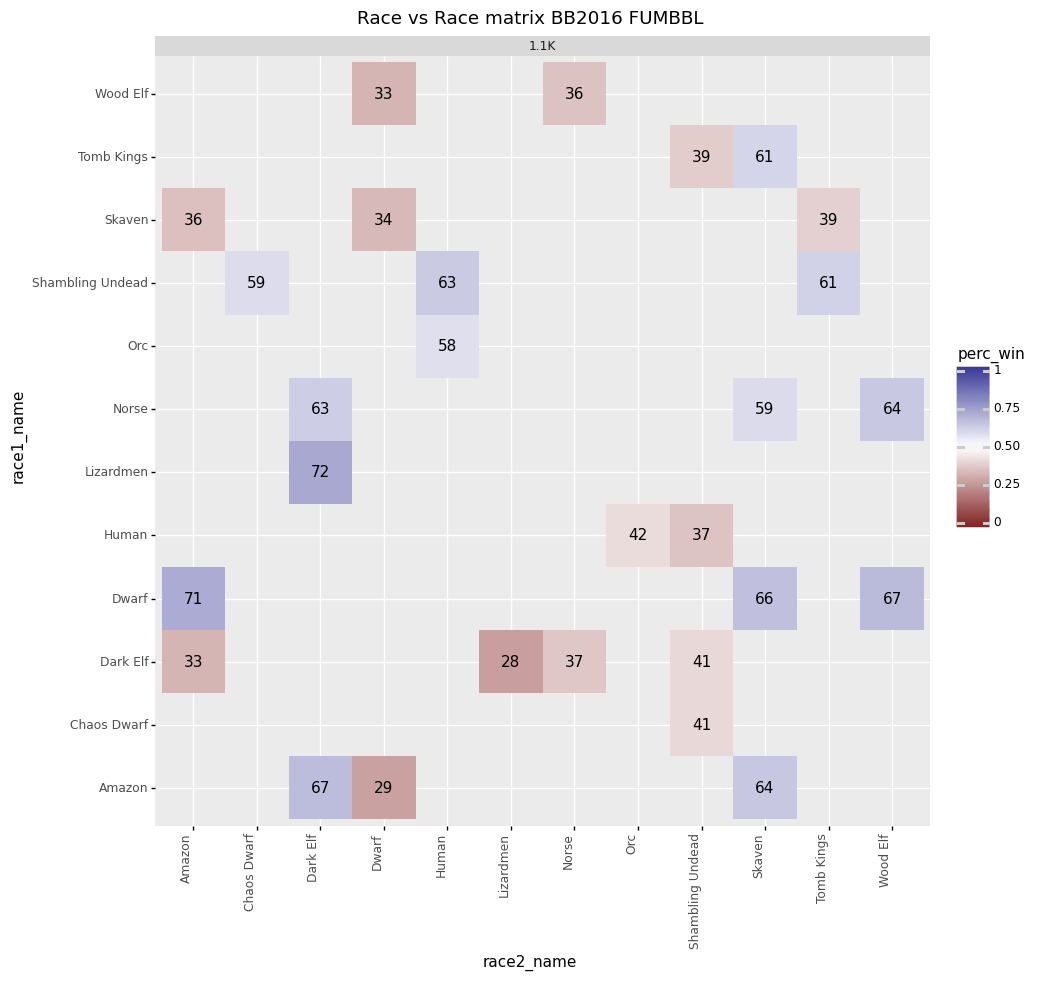

<ggplot: (-9223363264774385748)>

In [70]:
tv_bins = ['1.1K']
exclude = ['Snotling', 'Old World Alliance', 'Goblin', 'Nurgle', 'High Elf' , 'Slann', 'Elven Union', \
    'Halfling', 'Vampire', 'Chaos Chosen', 'Chaos Renegade', 'Ogre', 'Underworld Denizens', 'Necromantic Horror']

(p9.ggplot(data = df_pairs.query(
    '''
    n_games > 30 & \
    tv_bin in @tv_bins & \
    race1_name not in @exclude & \
    race2_name not in @exclude & \
    ruleset_version == "bb2016" & \
    contains_05 == 0
    '''), mapping = p9.aes(x = 'race1_name', y = 'race2_name', fill = 'perc_win', label = 'round(perc_win*100).astype(int)'))
    + p9.geom_tile()
    + p9.facet_wrap('tv_bin')
    + p9.geom_text()
    + p9.theme(axis_text_x= p9.element_text(rotation=90, hjust=1)) 
    + p9.scale_fill_gradient2(midpoint = 0.5, limits = [0, 1])
    + p9.theme(figure_size = (10, 10))
    + p9.coord_flip()
    + p9.ggtitle("Race vs Race matrix BB2016 FUMBBL"))

The problem with heatmaps is that we cannot display the uncertainty in the percentages.

So lets have a look at the teams I expect to be playing in 2022, Humans, Orcs and Lizardmen:



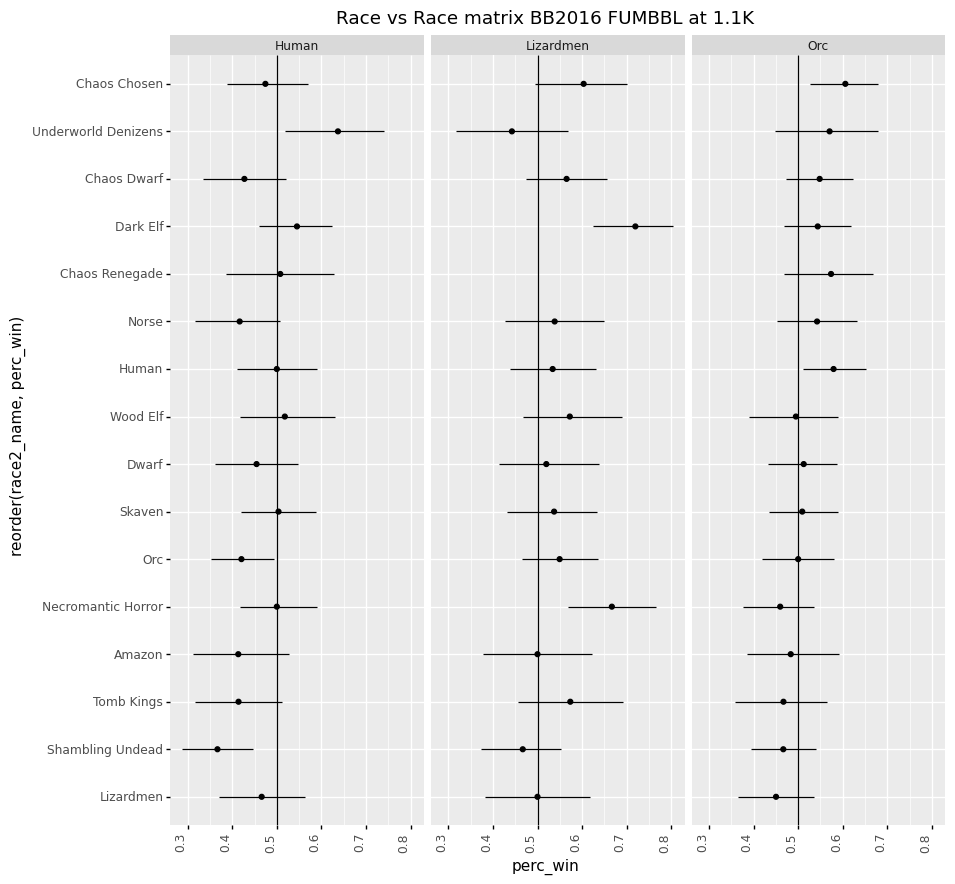

<ggplot: (-9223363264773829316)>

In [39]:
tv_bins = ['1.1K']
exclude = ['Snotling', 'Old World Alliance', 'Goblin', 'Nurgle', 'High Elf' , 'Slann', 'Elven Union']
include = ['Human', 'Orc', 'Lizardmen']

(p9.ggplot(data = df_pairs.query('n_games > 60 & tv_bin in @tv_bins & race1_name in @include & race2_name not in @exclude & ruleset_version == "bb2016"'), 
        mapping = p9.aes(y = 'perc_win', x = 'reorder(race2_name, perc_win)',  label = 'round(perc_win*100).astype(int)'))
    + p9.geom_point()
    + p9.geom_linerange(p9.aes(ymin = 'lower_CI', ymax = 'upper_CI'))
    + p9.facet_wrap('race1_name')
    #+ p9.geom_text()
    + p9.theme(axis_text_x= p9.element_text(rotation=90, hjust=1)) 
    + p9.theme(figure_size = (10, 10))
    + p9.coord_flip()
    + p9.geom_hline(yintercept = 0.5)
    + p9.ggtitle("Race vs Race matrix BB2016 FUMBBL at 1.1K"))

And now lets have a look at the top three teams in BB2016, do they any weaknesses in terms of opponents?

In [52]:
df_pairs


,race_name,ruleset_version,bb2020_nov21_tier,naf_tier,tv_bin,perc_win,n_wins,n_games,race1_name,race2_name,lower_CI,upper_CI
0,Shambling Undead,bb2016,1.0,1.0,1.1K,0.500000,66.0,132,Shambling Undead,Shambling Undead,0.414704,0.585296
1,Shambling Undead,bb2016,1.0,1.0,1.4K,0.500000,73.0,146,Shambling Undead,Shambling Undead,0.418896,0.581104
2,Shambling Undead,bb2016,1.0,1.0,1.7K,0.500000,24.0,48,Shambling Undead,Shambling Undead,0.358552,0.641448
3,Shambling Undead,bb2016,1.0,1.0,> 1850,0.500000,4.0,8,Shambling Undead,Shambling Undead,0.153524,0.846476
4,Shambling Undead,bb2020,1.0,1.0,1.1K,0.500000,5.0,10,Shambling Undead,Shambling Undead,0.190102,0.809898
...,...,...,...,...,...,...,...,...,...,...,...,...
2,Halfling,bb2016,3.0,3.0,1.4K,0.500000,8.0,16,Halfling,Halfling,0.255005,0.744995
3,Halfling,bb2020,3.0,3.0,< 950,0.500000,5.0,10,Halfling,Halfling,0.190102,0.809898
0,Halfling,bb2016,3.0,3.0,1.1K,0.428571,6.0,14,Halfling,Slann,0.169347,0.687796
1,Halfling,bb2016,3.0,3.0,1.4K,0.416667,2.5,6,Halfling,Slann,0.000000,0.710529


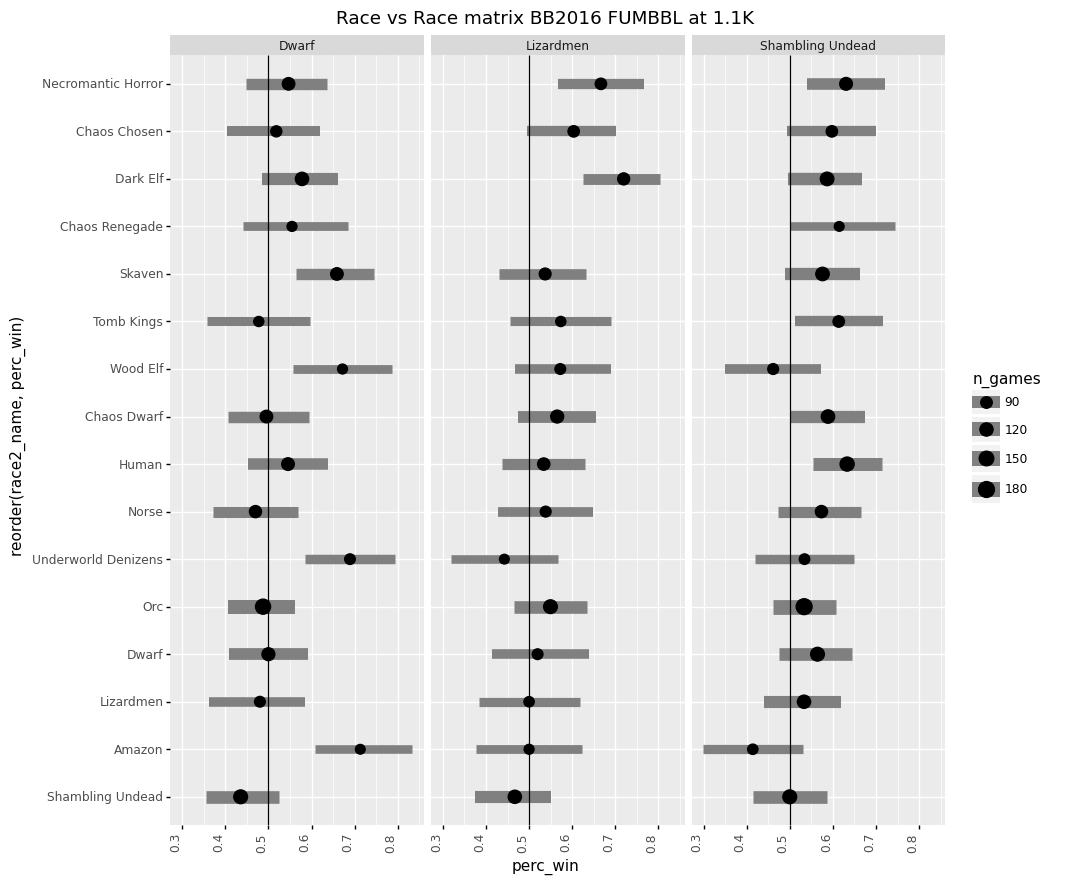

<ggplot: (8772080829865)>

In [51]:
tv_bins = ['1.1K']
exclude = ['Snotling', 'Old World Alliance', 'Goblin', 'Nurgle', 'High Elf' , 'Slann', 'Elven Union']
include = ['Lizardmen', 'Shambling Undead', 'Dwarf']

(p9.ggplot(data = df_pairs.query(
    '''
        n_games > 60 & \
        tv_bin in @tv_bins & \
        race1_name in @include & \
        race2_name not in @exclude & \
        ruleset_version == "bb2016"
    '''
    ), 
        mapping = p9.aes(y = 'perc_win', x = 'reorder(race2_name, perc_win)',
        size = 'n_games',  
        label = 'round(perc_win*100).astype(int)'))
    + p9.geom_linerange(p9.aes(ymin = 'lower_CI', ymax = 'upper_CI'), color = "grey")
    + p9.geom_point()
    + p9.facet_wrap('race1_name')
    #+ p9.geom_text()
    + p9.theme(axis_text_x= p9.element_text(rotation=90, hjust=1)) 
    + p9.theme(figure_size = (10, 10))
    + p9.coord_flip()
    + p9.scale_size_area()
    + p9.geom_hline(yintercept = 0.5)
    + p9.ggtitle("Race vs Race matrix BB2016 FUMBBL at 1.1K"))